# Read ME



Las datos de [entranamiento](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) y [prueba](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) fueron descargados de la plataforma [zoo galaxy](https://data.galaxyzoo.org/#section-21) correspondientes al Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).
Dichos datos estan almacenados en formato "[.pkl](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link)" en lugar del formato original de ".jpg" para faciliar el manejor de los mismos. Se trata de la información de 10,000 imagens de entrenamiento y 5,000 de prueba. La información se encuentra reducida a 75 pixles por imagenes siendo de 5x5 pixeles en tress canales de color. Para poder observar la galaxia es precsiso recosntruir la imagen

# Set up

## Packages

In [1]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive


In [2]:
import os
import io

import time

import math
import h5py
import random

import requests

import numpy as np
import matplotlib.pyplot as plt

# Machine learning tools for feature reduction and data scaling
from sklearn.decomposition import IncrementalPCA  # Performs incremental PCA for large datasets
from sklearn.preprocessing import StandardScaler  # Standardizes data before applying PCA
import joblib                                     # For saving and loading machine learning models


In [3]:
# Import Gaussian Mixture Model (GMM) for probabilistic clustering

from sklearn.mixture import GaussianMixture

## Funtions

In [4]:
def load_data(data='train'):
    """
    Downloads and loads preprocessed training or testing data from Google Drive.

    Parameters:
    - data (str): Specifies which dataset to load ('train' or 'test').

    Returns:
    - DATA (numpy array or None): The loaded dataset if successful, otherwise None.
    """

    # Define Google Drive file IDs for train and test datasets
    if data.lower() == 'train':
        file_id = '1-8JHObeY7kaU0qLt0p7WDFRJf6A6iYFN'  # File ID for training data

    elif data.lower() == 'test':
        file_id = '1bdjlyKp02O04uGkixX1E4mQMkUjvWRbL'  # File ID for test data

    else:
        print('Error: Type of data invalid')  # Handle incorrect input
        return None

    # Construct the download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Request file from Google Drive
    respuesta = requests.get(url)

    # Load the file as a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the dataset using joblib
    DATA = joblib.load(file_stream)

    # Confirm successful data loading
    print(f'{data.lower()} data loaded\nShape: {DATA.shape}')

    return DATA




def single_reconverter(data):
    """
    Takes a single PCA-transformed data point, reverses the PCA and scaling transformations,
    and normalizes it before reshaping it into an image.

    Parameters:
    - data (numpy array): A single data point in PCA-reduced form.

    Returns:
    - norm_centroides (numpy array): Reconstructed image (174x174x3).
    """
    data = data.reshape(1, -1)  # Ensure data is a 2D array
    centroides = scaler.inverse_transform(data)  # Reverse standard scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA transformation
    norm_centroides = normalized(centroides)  # Normalize pixel values
    norm_centroides = norm_centroides.reshape(174, 174, 3)  # Reshape into an image
    return norm_centroides


def reconverter(data):
    """
    Reconstructs multiple PCA-reduced data points back into images.

    Parameters:
    - data (numpy array): Multiple PCA-transformed data points.

    Returns:
    - norm_centroides (numpy array): Reconstructed images with normalized pixel values.
    """
    centroides = scaler.inverse_transform(data)  # Reverse scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA
    norm_centroides = normalized(centroides)  # Normalize pixel values
    return norm_centroides


def normalized(data):
    """
    Normalizes data to the range [0,1] using min-max scaling.

    Parameters:
    - data (numpy array): Input data.

    Returns:
    - norm (numpy array): Normalized data.
    """
    norm = (data - data.min()) / (data.max() - data.min())  # Min-max normalization
    return norm

def get_initial_means(X, init_params, n_components):
    """
    Run a GaussianMixture with max_iter=0 to output the initialization means
    """
    gmm = GaussianMixture(
        n_components=n_components, init_params=init_params, tol=1e-9, max_iter=0, random_state=31
    ).fit(X)
    return gmm.means_

def histogram(labels, clusters, name):
    """
    Plots a histogram of cluster distribution with a semi-logarithmic scale.

    Parameters:
    - labels (array-like): Cluster assignments for each sample.
    - bins (int or sequence): Number of bins or bin edges for the histogram.
    - name (str): File name for saving the plot.

    Returns:
    - None
    """

    # Define bin edges for the histogram, covering all cluster indices
    bins = np.arange(0,num_cluster+1)

    # Set up the figure size for better visualization
    plt.figure(figsize=(15, 4))

    # Set the title of the plot
    plt.title('Distribution for Each Cluster')

    # Use a semi-logarithmic scale to highlight differences in frequency
    plt.semilogy()

    # Plot a histogram showing the frequency of samples in each cluster
    frecuencia, clases, _ = plt.hist(labels, bins=bins, rwidth=0.8)

    # Label the axes
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

    # Set cluster numbers as x-axis ticks (centered between bins)
    plt.xticks(bins[:-1] + 0.5, bins[:-1])

    # Add a grid along the y-axis for better readability
    plt.grid(axis='y')

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Save the figure as a PDF file in the results directory
    plt.savefig(f'{root_result}{name}.pdf')

    # Display the plot
    plt.show()

    return None

## Directories

In [5]:
### Drive roots ####

root_train ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'

root_ipca = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
root_scaler = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

root_gmm = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/GMM.pkl'
root_result = '/content/drive/MyDrive/Practicas_Profesionales/Results/GMM/'

In [6]:
# ### Local roots ####

# root_train ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/train_data.pkl'
# root_test ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/test_data.pkl'

# root_ipca = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
# root_scaler = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

# root_som = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/GMM.pkl'
# root_result = '/home/tonathiu/Fisica/Practicas_Profesionales/Results/GMM/'

## Load Models

In [7]:
ipca = joblib.load(root_ipca)
scaler = joblib.load(root_scaler)

## Load Train Data

In [8]:
#train_data = joblib.load(root_train)
train_data = load_data('train')

train data loaded
Shape: (10000, 75)


# [Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html)

## Train

In [9]:
# Define the number of clusters for the Gaussian Mixture Model (GMM)
clusters = 15

# Initialize cluster centers using the K-Means++ method
ini = get_initial_means(train_data, 'k-means++', n_components=clusters)

# Train a Gaussian Mixture Model (GMM) on the training data
Model_GMM = GaussianMixture(
    n_components=clusters,  # Number of Gaussian components (clusters)
    means_init=ini,  # Use precomputed initial means from K-Means++
    tol=1e-7,  # Convergence tolerance (ensures higher precision)
    max_iter=1000,  # Maximum number of iterations to converge
    random_state=31  # Ensure reproducibility
).fit(train_data)  # Fit the model to the PCA-transformed training data


## Clasification

In [10]:
# Predict cluster labels for the training data using the trained Gaussian Mixture Model (GMM)
labels = Model_GMM.predict(train_data)

# Identify the unique cluster labels in the SOM grid
label = np.unique(labels)


## Centroides

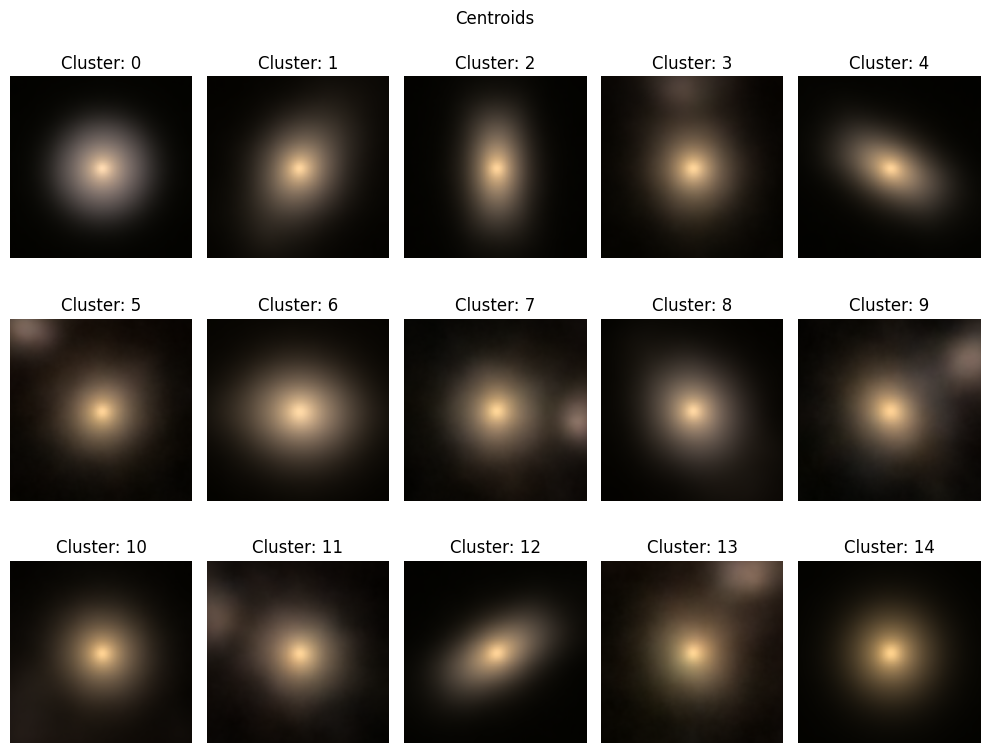

In [11]:
# Extract the mean vectors (centroids) from the trained Gaussian Mixture Model (GMM)
centroides = Model_GMM.means_

# Create a figure to visualize the centroids
plt.figure(figsize=(10, 8))

# Iterate over the GMM clusters to extract and plot each centroid
for i in range(clusters):  # Loop over all identified clusters
    # Convert the centroid vector back into an image representation
    center = single_reconverter(centroides[i])

    # Define the position in the subplot grid
    plt.subplot(int(clusters / 5), 5, i + 1)

    # Set the title for each centroid
    plt.title(f'Cluster: {i}')

    # Display the centroid image
    plt.imshow(center)
    plt.axis('off')  # Hide axes for better visualization

# Set a global title for the figure
plt.suptitle('Centroids')

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Save the figure as a PDF file in the results directory
plt.savefig(f'{root_result}Centroides_GMM.pdf')

# Display the visualization
plt.show()


## Histograma

In [12]:
# Obtain the number of clusters

num_cluster = len(label)



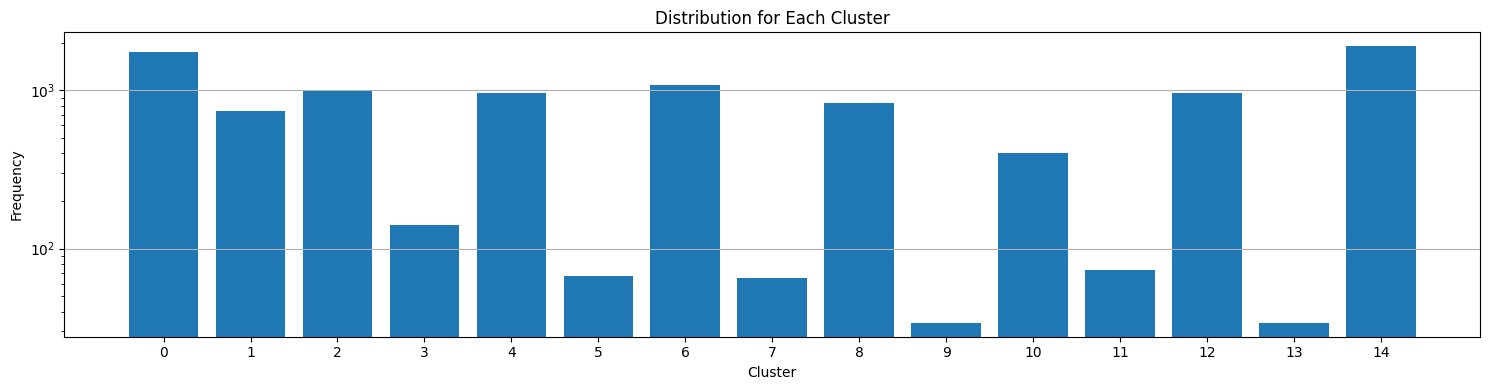

In [15]:
histogram(labels,num_cluster,'Histograma_GMM')

In [ ]:
# Initialize subplot index
ploteo = 1

# Create a figure with dynamic height based on the number of clusters
plt.figure(figsize=(10, 3 * num_cluster))

# Iterate over each unique cluster label
for etq in label:
    cuenta = 1  # Counter to limit the number of images per cluster

    # Loop through all samples in the dataset
    for i in range(len(train_data)):
        rand = random.random()  # Generate a random number for sampling

        # Select images that belong to the current cluster with a probability filter (rand > 0.5)
        if etq == labels[i] and rand > 0.5:
            # Convert the PCA-transformed sample back to an image
            img = single_reconverter(train_data[i])

            # Plot the image in a grid (num_cluster x 5 layout)
            plt.subplot(num_cluster, 5, ploteo)
            plt.imshow(img)
            plt.axis('off')  # Hide axis for cleaner visualization

            # Set a title for the third image in each cluster
            if cuenta == 3:
                plt.title(f'Cluster {etq}')

            ploteo += 1  # Increment subplot index
            cuenta += 1  # Increment the image counter for this cluster

        # Stop after plotting 5 images per cluster
        if cuenta > 5:
            break

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the figure as a PDF file in the results directory
plt.savefig(f'{root_result}Clusters_GMM.pdf')

# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Save

In [ ]:
joblib.dump(Model_GMM, root_gmm)

['/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/GMM.pkl']

# Test Model

## Load Model

In [ ]:
GMM_model = joblib.load(root_gmm)

## Load Data

In [ ]:
Test_data = joblib.load(root_test)

## Classification


In [ ]:
# Predict cluster labels for the test dataset using the trained GMM model
labels = GMM_model.predict(Test_data)

# Identify the unique cluster labels in the SOM grid
label = np.unique(labels)

## Histogram

In [ ]:
# Determine the number of unique clusters found in the test data
num_cluster = len(label)

# Define bin edges for histogram, covering all cluster indices

bins = np.arange(0,num_cluster+1)

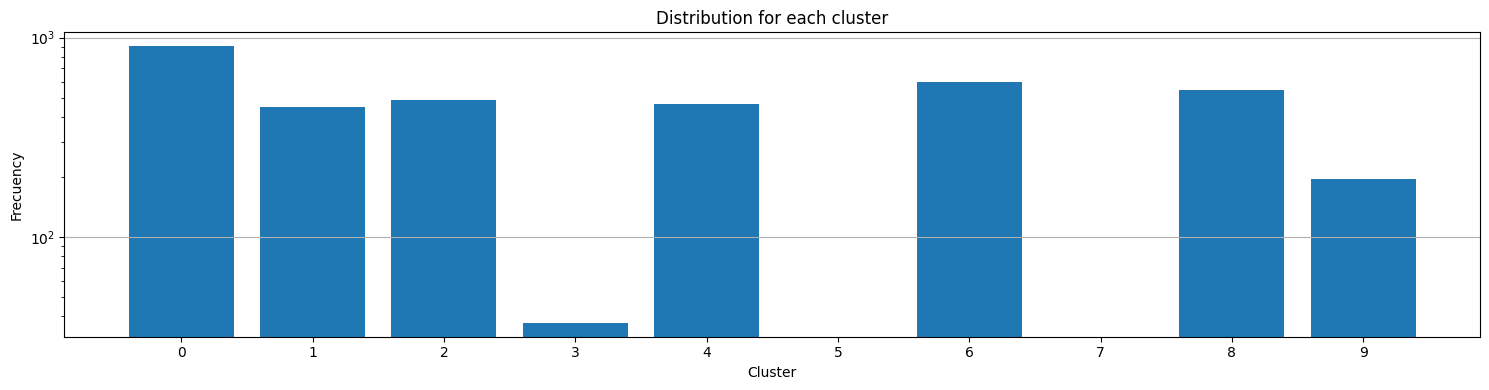

In [ ]:
# Set up the figure size for better visualization
plt.figure(figsize=(15,4))

# Set the title of the plot
plt.title('Distribution for each cluster')

# Use a semi-logarithmic scale to highlight differences in frequency
plt.semilogy()

# Plot a histogram showing the frequency of samples in each cluster
frecuencia,clases,_=plt.hist(labels,bins=bins,rwidth=0.8)

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Frecuency')

# Set cluster numbers as x-axis ticks (centered between bins)
plt.xticks(bins[:-1]+.5,bins[:-1])

# Add a grid along the y-axis for better readability
plt.grid(axis='y')

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

*************** 

*************** 

*************** 

*************** 

*************** 

*************** 

*************** 

*************** 

*************** 

*************** 



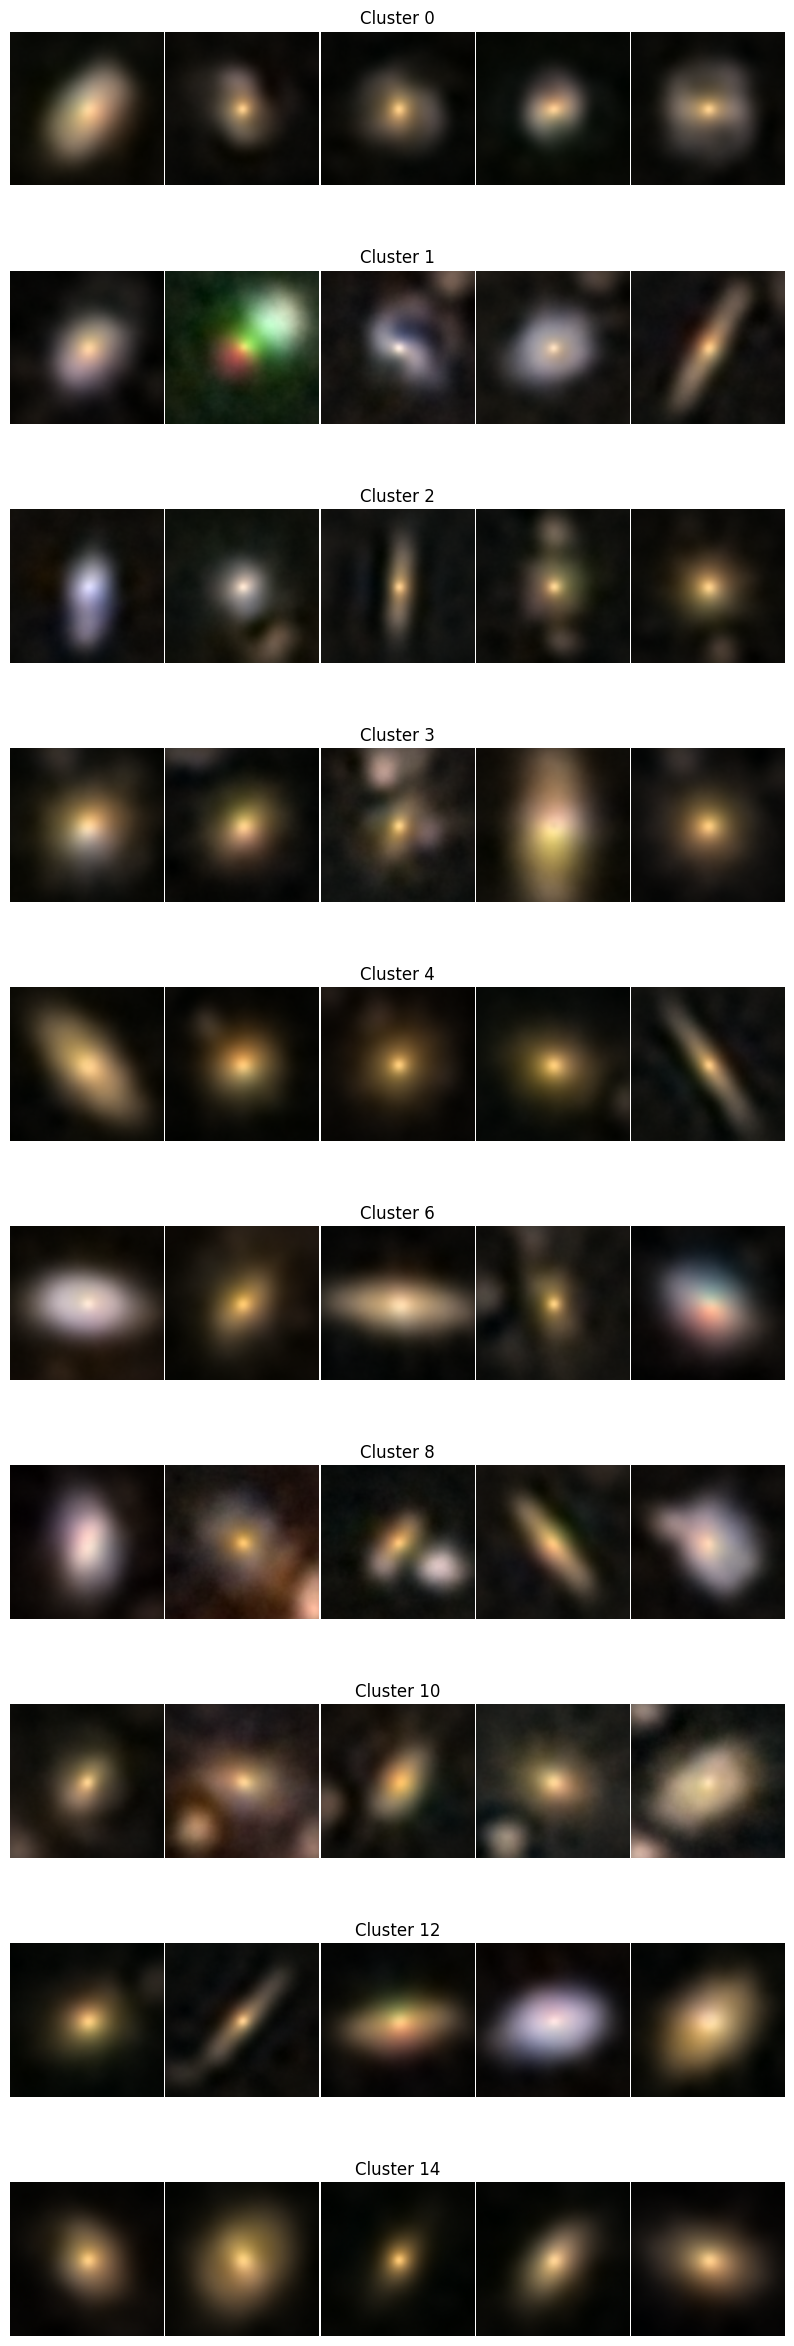

In [ ]:
ploteo = 1
plt.figure(figsize=(10, 3*num_cluster))

for etq in label:
  cuenta = 1
  for i in range(len(Test_data)):
    rand = random.random()
    if etq == labels[i]:# and rand > 0.5:


      img = single_reconverter(Test_data[i])

      plt.subplot(num_cluster,5,ploteo)
      plt.imshow(img)
      plt.axis('off')
      if cuenta == 3:
        plt.title(f'Cluster {etq}')

      #print(ploteo,cuenta,etq)

      ploteo += 1
      cuenta += 1


    if cuenta > 5:
      print(15*'*','\n')
      break
plt.subplots_adjust(wspace=0.01, hspace=0.5)
plt.show()